## Mounting to Drive


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

DATA_PATH = 'gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Dataset/'

Mounted at /content/gdrive


##Importing the essential libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import layers, regularizers, optimizers
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import re
plt.switch_backend('agg')
%matplotlib inline

Using Theano backend.


### Setting Some Parameters

In [0]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# Data Preprocessing

## Importing Datasets and Data Cleaning Process

In [0]:
# Setting Data Path to dataset folder
DATA_PATH = 'gdrive/My Drive/Capstone Deliverables/Dataset/'

# Setting the data to the contents of the dataset
data = DATA_PATH + 'yelp.csv'

# Reading data file contents to sample using pandas library
sample = pd.read_csv(data)

# Cleaning data - dropping NA values
sample = sample.dropna()

# Resetting index position
sample = sample.reset_index(drop=True)

## Data Evaluation

In [0]:
print('Shape of dataset :',sample.shape)
print('Data columns :', sample.columns)
print('No. of unique types :',len(set(sample.type)))
print('No. of unique stars :',len(set(sample.stars)))
print('No. of unique texts :',len(set(sample.text)))
print('Data for top 5 rows :', sample.head())
sample.describe(include='all')

Shape of dataset : (10000, 10)
Data columns : Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')
No. of unique types : 1
No. of unique stars : 5
No. of unique texts : 9998
Data for top 5 rows :               business_id        date               review_id  stars  \
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type  \
0  My wife took me here on my birthday for breakf...  review   
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Cha

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
count,10000,10000,10000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,4174,1995,10000,NaN,9998,1,6403,NaN,NaN,NaN
top,ntN85eu27C04nwyPa8IHtw,2011-03-28,wrdSVbYnPayOIsAjYUP-3A,NaN,Great service,review,fczQCSmaWF78toLEmb0Zsw,NaN,NaN,NaN
freq,37,21,1,NaN,2,10000,38,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.777500,NaN,NaN,NaN,0.876800,1.409300,0.701300
std,NaN,NaN,NaN,1.214636,NaN,NaN,NaN,2.067861,2.336647,1.907942
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000


## Removing stopwords using NLTK

In [0]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
exclusion_list = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]

for word in exclusion_list:
    stop_words.remove(word)

In [0]:
def clean(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    
    # Remove anything else and just keep the alphabets    
    review = re.sub('[^a-zA-Z]', ' ', string)
        
    # Convert the review to lovercase
    review = review.lower()
    
    # Split the reviews into words
    review_words = review.split()
    
    # Remove any stop words
    cleaned_words = [word for word in review_words if not word in stop_words]   
        
    # Join to get a clean review
    clean_review = ' '.join(cleaned_words)
    
    return clean_review

In [0]:
macronum=sorted(set(sample.stars))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

sample.stars = sample.stars.apply(fun)

In [0]:
reviews = []
ratings = []

for idx in range(sample.text.shape[0]):
    # BeautifulSoup to remove some html tags and unwanted characters
    review = BeautifulSoup(sample.text[idx]) 
    reviews.append(str(review.get_text().encode('ascii','ignore')))
    ratings.append(sample.stars[idx])

In [0]:
for i in range(len(reviews)):
  reviews[i] = clean(reviews[i])

## Tokenizer and Word Emebdddings

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 33289


In [0]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(sample.stars))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
data = data[:-nb_validation_samples]
labels = labels[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (10000, 1000)
Shape of Label Tensor: (10000, 5)


In [0]:
glove_data = DATA_PATH + 'glove.6B.100d.txt'

embeddings_index = {}
f = open(glove_data,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

## Building Model

In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# l_conv1= Conv1D(128, 5, activation='relu')(embedded_sequences)
# l_pool1 = MaxPooling1D(5)(l_conv1)
# l_conv2= Conv1D(128, 5, activation='relu')(l_pool1)
# l_pool2 = MaxPooling1D(5)(l_conv2)
# l_conv3= Conv1D(128, 5, activation='relu')(l_pool2)
# l_pool3 = MaxPooling1D(5)(l_conv3)
# l_flat = Flatten()(l_pool3)
# l_dense = Dense(128, activation='relu')(l_flat)
# preds = Dense(len(macronum), activation='sigmoid',activity_regularizer = regularizers.l1(0.00001))(l_dense)
# rmsprop = optimizers.RMSprop(lr=learning_rate)
# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer=rmsprop,
#               metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         3329000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
__________

In [0]:
import keras as keras
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

In [0]:
best_batch_size= 128
best_epochs = 15
best_learning_rate= 0.001
history=model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[time_callback],
          epochs=best_epochs, batch_size=best_batch_size)
times = time_callback.times

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Train on 6000 samples, validate on 2000 samples
Epoch 1/15
6000/6000 [==============================] - 170s 28ms/step - loss: 1.4673 - acc: 0.3500 - val_loss: 1.5362 - val_acc: 0.3355
Epoch 2/15
6000/6000 [==============================] - 167s 28ms/step - loss: 1.4326 - acc: 0.3603 - val_loss: 1.3884 - val_acc: 0.3405
Epoch 3/15
6000/6000 [==============================] - 169s 28ms/step - loss: 1.3478 - acc: 0.3808 - val_loss: 1.2984 - val_acc: 0.3765
Epoch 4/15
6000/6000 [==============================] - 166s 28ms/step - loss: 1.2661 - acc: 0.4192 - val_loss: 1.2418 - val_acc: 0.4265
Epoch 5/15
6000/6000 [==============================] - 167s 28ms/step - loss: 1.1887 - acc: 0.4602 - val_loss: 1.1910 - val_acc: 0.4555
Epoch 6/15
6000/6000 [==============================] - 167s 28ms/step - loss: 1.1091 - acc: 0.4905 - val_loss: 1.2033 - val_acc: 0.4690
Epoch 7/15
6000/6000 [==============================] - 170s 28ms/step - loss: 1.0417 - acc: 0.5405 - val_loss: 1.1804 - val_acc: 

## Saving Model Weights

In [0]:
model.save_weights('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/Models/CNN.h5')

## Graph Plots

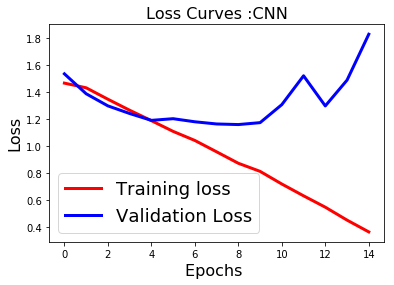

In [0]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/loss_cnn.png')
plt.show()

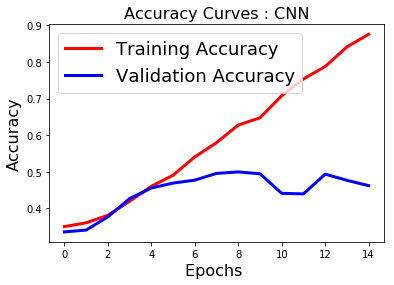

In [0]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/accuracy_cnn.png')
plt.show()

## Predictions and Accuracy

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=256, verbose=1)
print('Test accuracy:', score[1])

2000/2000 [==============================] - 16s 8ms/step
Test accuracy: 0.7319999976158142


## Time per epoch

In [0]:
times = np.round(times,2)
print(times)

[169.65 166.57 168.6  166.43 167.35 167.14 169.62 166.9  169.59 167.
 169.31 169.56 166.9  169.44 167.63]
